In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

In [2]:
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

In [3]:
if RunningInCOLAB:
    cd /content/gdrive/MyDrive/DL_Small_Project

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from datetime import datetime
from tqdm.notebook import tqdm

# Model Options

Given the following 2 model options, 

**Multiclass Classifier: 3-Classes classifier**
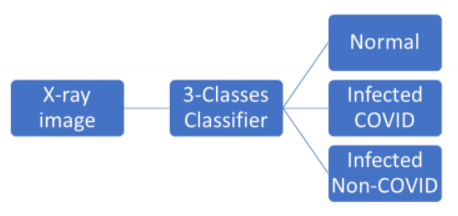

This model is expected to function like this to differentiate between the 3 classes. 

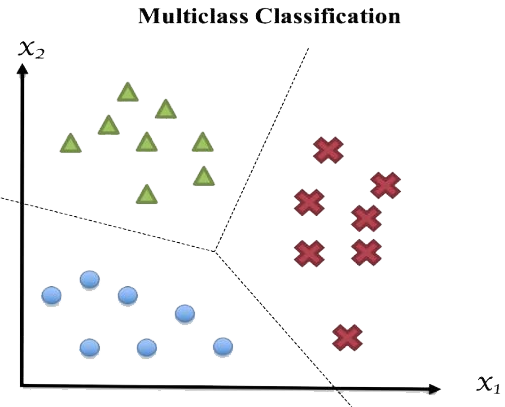

However, this model is slightly more complex as it requires the model to differentiate said 3 possible classes of images. It is also expected to **take longer** for convergence to occur. In addition, this approach is **less ideal** for differentiating classes that share strong similarities. `Infected Covid-19` and `Infected Pneumonia` classes of X-ray images are similar looking, and this approach might not be ideal for learning parameters to differentiate between these 2 classes due to the presence of the remaining `normal` class of X-ray images.

**Cascaded Binary Classifier**
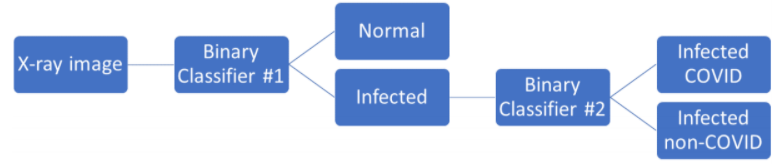

This model has the special trick of using the `one vs rest` approach of using a binary classifier as represented by the following image.

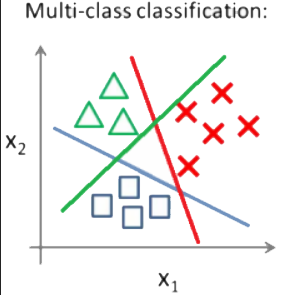

Although a linear model is simpler and therefore easier to converge, it means that there must be at least **2 binary classifiers** working in series (AKA cascade) to differentite between the 3 classes. This unfortunately means that for many classes classification, it is less ideal to use this approach for classifying purposes. 

However, since the problem at hand only has 3 classes, it is still alright to make use of this approach. This approach has a nice **advantage** of training the model well to isolate and learn obvious features within the image, which is not so possible if the classes share strong similarities. This is observed by the fact that the class `infected covid-19` and `infected pneumonia` have similar looking X-ray images, whereas it there is a significant feature difference between `normal` and `infected` classes of X-ray images.



# Model Choice

Taking a step back and observing the data and purpose of the model, we want to classify given X-ray images of patients to assist Doctors in diagnosing patients. Along with prior knowledge regarding COVID-19 and Pneumonia, which are lung prevalent diseases, this would definitely mean that the **lung regions in X-ray images would be obstructed (appear whiter) as compared to lung regions in normal patients**.

Since both X-ray images of infected (either COVID-19 or Pneumonia) would have **similar** looking X-ray images that would highly differ (in terms of the lung regions) from the normal person's X-ray images, it makes sense to train a cascaded binary classifer instead. Classifying a normal person or an infected person is 1 kind of classification, whereas differentiating between an illness (diagnosing) would be another kind of classification. It is **unlikely** that the model would be able to learn parameters well to differentiate features between `infected covid-19` and `infected pneumonia` through training of a multiclass classification model.

Model1 would be in charge of learning parameters to differentiate between `normal` vs `infected` X-ray images, whereas Model2 would be in charge of learning parameters that differentiate between `infected covid-19` and `infected pneumonia` X-ray images.

# Dataset Objects

We have custom dataset classes located in the python script: `model1Dataset.py` & `model2Dataset.py`.

In [5]:
from model1Dataset import Lung_Train_Dataset as model1Train
from model1Dataset import Lung_Val_Dataset as model1Val
from model1Dataset import Lung_Test_Dataset as model1Test
from model2Dataset import Lung_Train_Dataset as model2Train
from model2Dataset import Lung_Val_Dataset as model2Val
from model2Dataset import Lung_Test_Dataset as model2Test

Let's check that our custom dataset classes work!

In [6]:
ld_train = model1Train()
ld_train.describe()
ld_val = model1Val()
ld_val.describe()
ld_test = model1Test() 
ld_test.describe() 

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder ./dataset/train/infected/non-covid: 2530 images.

This is the validation dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid: 8 images.
 - val_infected_non_covid, in folder ./dataset/va

Also, let's see how a `normal` class `train` image looks like!

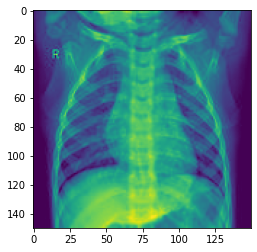

In [7]:
ld_train.show_img('train_normal',1)

# Dataloaders

In [8]:
batch_size = 4
train_loader = DataLoader(ld_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = batch_size, shuffle = True)

## Input Normalization

(you are expected to discuss the typical data processing operations to be applied to your  images. Typically, you have seen in the Demo Notebook, that our images needed some  normalization was one, but why did we need it anyway? Are there other pre-processing  operations that are needed for our images?)


During training, a neural network would expect input values of: `[0, 1]`. This is the reason we had to perform the pixel normalization from possible values of `[0, 255]` to `[0, 1]` by dividing by `255`. In addition, Convergence is usually faster if the average of each input variable over the training set is close to **0**. This [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) yields the inspiration of doing so, as it greatly improves training speed. Thus, we are going to conduct **normalization** as a pre-processing process of the images in the dataset.


Here, we have defined a function `getMeanStd` that computes the mean and standard deviation of all the pixel values only for our **training images**. We do so, as we are not supposed to prepare our model for either `validation` or `test` images.

In [9]:
def getMeanStd(dataset, loader, loaderName, image_size=(150, 150)):
    totalSum = 0
    numPixels = len(dataset) * image_size[0] * image_size[1]
    print ("Computing Mean: ")
    for batch in tqdm(loader):
        totalSum += batch[0].sum()
        mean = totalSum / numPixels
    sumSquaredError = 0
    print ("Computing Std: ")
    for batch in tqdm(loader):
        sumSquaredError += ((batch[0] - mean).pow(2)).sum()
    std = torch.sqrt(sumSquaredError/numPixels)
    print ("Loader: {}. Mean: {}, Std: {}".format(loaderName, mean, std))
    return mean, std

In [10]:
trainMean, trainStd = getMeanStd(ld_train, train_loader, "train_loader")

Computing Mean: 


  0%|          | 0/1304 [00:00<?, ?it/s]

Computing Std: 


  0%|          | 0/1304 [00:00<?, ?it/s]

Loader: train_loader. Mean: 0.4824069142341614, Std: 0.23631195724010468


Since in the later stages, we have to do the same `pre-processing` process for loading in either `validation` or `test` images, we save the transform in an easy to call variable: `normalize_transform`. We would use this variable as an input to our `custom dataset classes` in order to introduce it to the `pre-processing` pipeline process.

In [11]:
normalize_transform = transforms.Normalize(trainMean, trainStd)

After computing the `mean` and `standard deviation` of the **training images**, we can go ahead and redefine our `custom dataset classes`

In [12]:
ld_train_normalized = model1Train(normalize_transform)
ld_val_normalized = model1Val(normalize_transform)
ld_test_normalized = model1Test(normalize_transform)

Next, we can also define our new `normalized dataloaders` as well.

In [13]:
train_loader_normalized = DataLoader(ld_train_normalized, batch_size = batch_size, shuffle = True)
test_loader_normalized = DataLoader(ld_test_normalized, batch_size = batch_size, shuffle = True)
val_loader_normalized = DataLoader(ld_val_normalized, batch_size = batch_size, shuffle = True)

Finally, just as a test, we should expect to see the new `mean` and `standard deviation` of our normalized loaders to be `0` and `1` respectively.

In [14]:
train_normalized_mean, train_normalized_std = getMeanStd(ld_train_normalized, train_loader_normalized, "train_loader_normalized")

Computing Mean: 


  0%|          | 0/1304 [00:00<?, ?it/s]

Computing Std: 


  0%|          | 0/1304 [00:00<?, ?it/s]

Loader: train_loader_normalized. Mean: 2.588023733096634e-07, Std: 1.0000001192092896


As expected, we do have a **standard normal distribution**, in which we have `0 mean` and `standard deviation` of `1`.

# Dataset Analysis

## Distribution of Images Among Classes

In [15]:
def distributionPlotter(labels, distributions, title):
    x = np.arange(len(labels))
    width = 0.3

    fig, ax = plt.subplots(figsize=(12,6))
    rects1 = ax.bar(x - 3*width/3, distributions[0], width, label="Train")
    rects2 = ax.bar(x, distributions[1], width, label="Val")
    rects3 = ax.bar(x + 3*width/3, distributions[2], width, label="Test")
    
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + 0.5*len(rects)* rect.get_width() / len(labels), height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()

    plt.show()

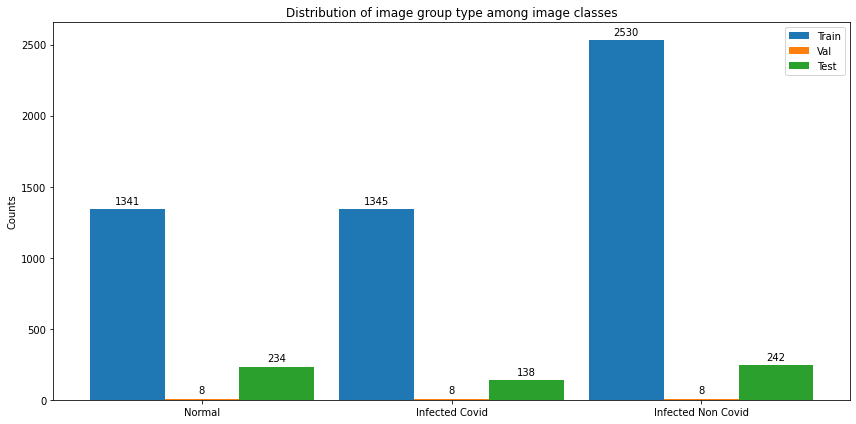

In [16]:
labels = ["Normal", "Infected Covid", "Infected Non Covid"]
distributions = [list(ld_train.dataset_numbers.values()), list(ld_val.dataset_numbers.values()), list(ld_test.dataset_numbers.values())]
distributionPlotter(labels, distributions, "Distribution of image group type among image classes")

Based on the figure above, we can clearly see that the dataset is not unformly distributed among the image classes. Although, the classes: `Normal` and `Infected Covid` have roughly the same number of `train` images and `val` images, there is about `1.7x` the number of `test` images for `Normal` class as compared to the `Infected Covid` class.

Take the class `Infected Non-Covid` for instance, it has `~ 2x` the number of `train` images as compared to the number of `train` images as compared to that of the classes: `Normal` and `Infected Covid`. This is not ideal, as the model is **less optimized** in learning parameters to differentiate for the class `Infected Covid` class which is of the **higher priority** here, and instead will learn to better differentiate images for the class `Infected Non Covid`.

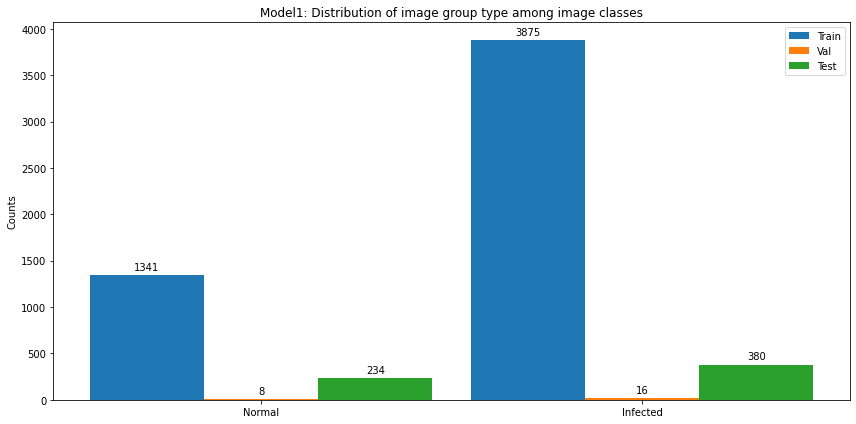

In [17]:
labels = ["Normal", "Infected"]
distributions = [[list(ld_train.dataset_numbers.values())[0], sum(list(ld_train.dataset_numbers.values())[1:])],
                 [list(ld_val.dataset_numbers.values())[0], sum(list(ld_val.dataset_numbers.values())[1:])],
                 [list(ld_test.dataset_numbers.values())[0], sum(list(ld_test.dataset_numbers.values())[1:])]]
title = "Model1: Distribution of image group type among image classes"
distributionPlotter(labels, distributions, title)

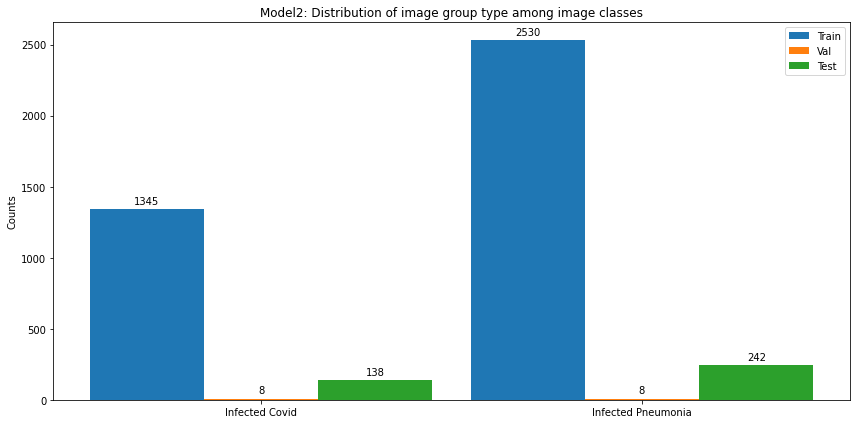

In [18]:
labels = ["Infected Covid", "Infected Pneumonia"]
distributions = [[list(ld_train.dataset_numbers.values())[1], list(ld_train.dataset_numbers.values())[2]],
                 [list(ld_val.dataset_numbers.values())[1], list(ld_val.dataset_numbers.values())[2]],
                 [list(ld_test.dataset_numbers.values())[1], list(ld_test.dataset_numbers.values())[2]]]
title = "Model2: Distribution of image group type among image classes"
distributionPlotter(labels, distributions, title)

## Average Image
Now let’s see what the average image looks like for each class. To compute the average image, we can take the average value of each pixel across all observations.

  0%|          | 0/1341 [00:00<?, ?it/s]

  0%|          | 0/2530 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

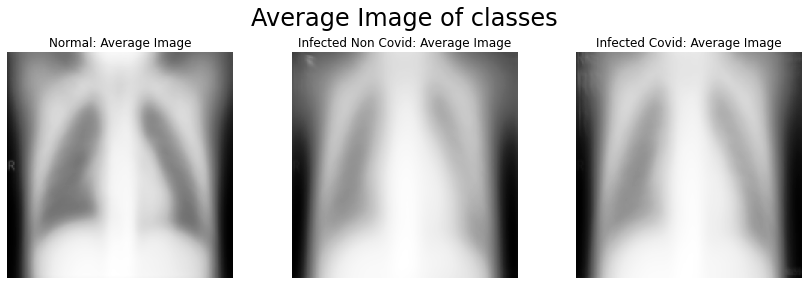

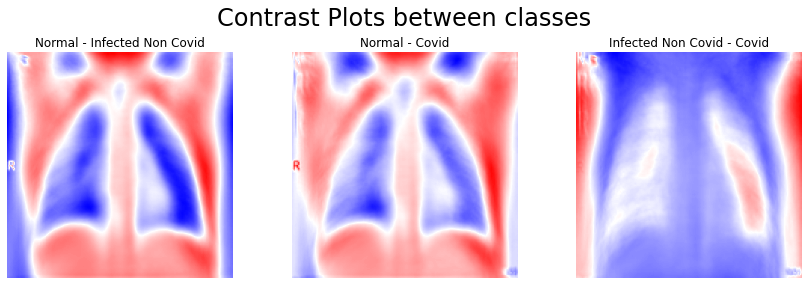

In [19]:
def find_mean_img(loader, title, size = (64, 64)):
    combined = np.zeros(size)
    for index in tqdm(range(loader.dataset_numbers["train_" + title])):
        combined += loader.open_img("train_"+ title, index)
    # calculate the average
    mean_img = combined / loader.dataset_numbers["train_" + title]
    return mean_img

norm_mean = find_mean_img(ld_train_normalized, 'normal', (150, 150))
pneu_mean = find_mean_img(ld_train_normalized, 'infected_non_covid', (150, 150))
cov_pneu_mean = find_mean_img(ld_train_normalized, "infected_covid", (150, 150))

fig, axs = plt.subplots(1,3, figsize=(12, 4))
fig.suptitle("Average Image of classes", fontsize=24)
axs[0].imshow(norm_mean*255, cmap="Greys_r")
axs[0].set_title("Normal: Average Image")
axs[0].axis('off')
axs[1].imshow(pneu_mean*255, cmap="Greys_r")
axs[1].set_title("Infected Non Covid: Average Image")
axs[1].axis('off')
axs[2].imshow(cov_pneu_mean*255, cmap="Greys_r")
axs[2].set_title("Infected Covid: Average Image")
axs[2].axis('off')
fig.tight_layout()

# Contrast between avg images
contrast_mean1 = norm_mean - pneu_mean
contrast_mean2 = norm_mean - cov_pneu_mean
contrast_mean3 = pneu_mean - cov_pneu_mean

fig, axs = plt.subplots(1,3, figsize=(12,4))
fig.suptitle("Contrast Plots between classes", fontsize=24)
axs[0].imshow(contrast_mean1, cmap='bwr')
axs[0].set_title('Normal - Infected Non Covid')
axs[0].axis('off')
axs[1].imshow(contrast_mean2, cmap="bwr")
axs[1].set_title('Normal - Covid')
axs[1].axis('off')
axs[2].imshow(contrast_mean3, cmap="bwr")
axs[2].set_title('Infected Non Covid - Covid')
axs[2].axis('off')
fig.tight_layout()

**Some details about X-rays**: The image is developed with respect to the **intensity** of the X-rays hitting the film. Thus, the darker the region, the greater the absorption of X-rays in that region of the radioactive image film. **Fluids** are known to absorb X-rays, therefore in regions of fluids, the image film shows a lighter colour.

**Some details about contrast-plots**: `RED` represents postive regions `(+)`, `WHITE` represents neutral regions `(0)` and `BLUE` represents negative regions `(-)`.

Looking at the above average images for each class, we can clearly see that the `Normal` average image has a significant, easily identifiable segments of dark grey region corresponding to **air-filled** lungs. It is very clear that the average image of the classes `Infected Non Covid` and `Infected Covid` have less identifiable lung regions - that there are more obstructions in the chest area as compared to the `Normal` average image. Notably, the average image of the `Infected Non Covid` class has detectable more obstructions (fluid) in the lung cavities as compared to the average image of the `Infected Covid` class.

Looking at the `contrast plots`, it basically **verifies** our observations made above from the `black & white` average images. `Normal-infected Non Covid` makes sense as it shows a largely different lung section. The pixel values of the lung regions for `Infected Non Covid` class is much larger (AKA brighter and whiter) than the corresponding pixel values of the lung regions for `Normal` class.

# Data Augmentation

As a result of the biased distribution of images among the different classes, we will turn to data augmentation to try to make the trainng data more uniform. 

We conduct the following augmentation:
1. Translation
2. Scaling
3. Rotation

In [20]:
def imageAugmenter(img, seed=42, debug=False, isTensor=False):
    torch.manual_seed(seed)   # give it a fixed seed!
    class args:
        FILL_COLOR = 0.0

        ROT_RANGE = 5
        TRANS_RANGE_X = 0.1
        TRANS_RANGE_Y = 0.1
        MIN_SCALE = 0.9
        MAX_SCALE = 1.1

        MIN_ROTATION = -15
        MAX_ROTATION = 15
        MIN_TRANSFORM = -5
        MAX_TRANSFORM = 5


    augmentTransform = transforms.Compose([
    transforms.RandomAffine(args.ROT_RANGE, translate=(args.TRANS_RANGE_X, args.TRANS_RANGE_Y), scale=(args.MIN_SCALE, args.MAX_SCALE))
    ])
    
    if not isTensor:
        augmentedImg = augmentTransform(transforms.functional.to_tensor(img).float())
    else:
        augmentedImg = augmentTransform(img)

    if debug:
        fig, axs = plt.subplots(1, 2, figsize=(12,8))
        axs[0].imshow(img)
        axs[0].set_title("Before Augmentation")
        trans = transforms.ToPILImage()
        axs[1].imshow(trans(augmentedImg))
        axs[1].set_title("After Augmentation")
        
    return augmentedImg

c:\users\jamesong7822\appdata\local\programs\python\python39\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2196, 0.2235, 0.2314],
         [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2275, 0.2353],
         [0.0000, 0.0000, 0.0000,  ..., 0.2157, 0.2000, 0.2000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.5137, 0.3333, 0.3725],
         [0.0000, 0.0000, 0.0000,  ..., 0.3451, 0.3451, 0.3765],
         [0.0000, 0.0000, 0.0000,  ..., 0.3529, 0.3451, 0.3765]]])

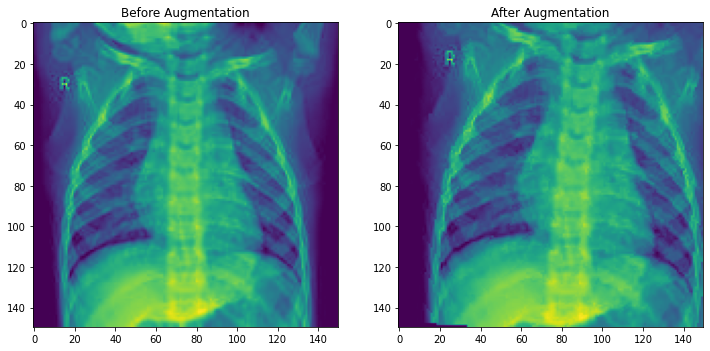

In [21]:
imageAugmenter(ld_train.open_img("train_normal", 1), debug=True)

In [22]:
from model import ResNet50

In [23]:
model1 = ResNet50(1, 2)

In [24]:
# Model Definition (3 classes classifier)

# Resnet50 model Modified from https://github.com/a-martyn

class block(nn.Module):
    def __init__(self, filters, subsample=False):
        super().__init__()
        s = 0.5 if subsample else 1.0
        
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()

        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    def shortcut(self, z, x):
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x        
    
    def forward(self, x, shortcuts=False):
        print ("input: ", x.shape)
        z = self.conv1(x)
        print ("After conv1: ", z.shape)
        z = self.bn1(z)
        print ("After bn1: ", z.shape)
        z = self.relu1(z)
        print ("After relu1: ", z.shape)
        
        z = self.conv2(z)
        z = self.bn2(z)

        if shortcuts:
            z = self.shortcut(z, x)

        z = self.relu2(z)
        
        return z
    

class ResNet(nn.Module):
    def __init__(self, n, shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts
        
        self.convIn = nn.Conv2d(1, 150, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnIn   = nn.BatchNorm2d(150, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        self.stack1 = nn.ModuleList([block(150, subsample=False) for _ in range(n)])

        self.stack2a = block(32, subsample=True)
        self.stack2b = nn.ModuleList([block(32, subsample=False) for _ in range(n-1)])

        self.stack3a = block(64, subsample=True)
        self.stack3b = nn.ModuleList([block(64, subsample=False) for _ in range(n-1)])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fcOut   = nn.Linear(64, 10, bias=True)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()      
        
    def forward(self, x):     
        z = self.convIn(x)
        z = self.bnIn(z)
        z = self.relu(z)
        
        print ("Before stack1: ", z.shape)
        for l in self.stack1: z = l(z, shortcuts=self.shortcuts)
        
        print ("After stack1: ", z.shape)
        z = self.stack2a(z, shortcuts=self.shortcuts)
        for l in self.stack2b: 
            z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack3a(z, shortcuts=self.shortcuts)
        for l in self.stack3b: 
            z = l(z, shortcuts=self.shortcuts)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        return self.softmax(z)



In [25]:
# Training 
# Display progress over time, show time at which epoch ends, loss values on train set and test set
# Display accuracy also 
# Save model regularly 
# Get history of losses and accuracy?

def train_one_epoch(model, device, train_loader, optimizer, epoch, epochs): 
    print('training now...')
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#         data[0] = imageAugmenter(data[0], isTensor=True)
        datetimeobj = datetime.now()
        data, target = data.to(device), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target.squeeze())
        print (loss)
        train_loss += loss
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    print('Train Epoch: {}/{} @  {}\tTrain Loss: {:.4f}'.format(epoch, epochs, datetime.now(), train_loss))

def test_one_epoch(model, device, test_loader, datatype):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device, dtype=torch.long)
            output = model(data)
            test_loss += F.nll_loss(output, target.squeeze(), reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(datatype,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return model

def train():
    trainloss_history = []
    testacc_history = []
    valloss_history = [] 
    valacc_history = []

    class args:
        batch_size = 64 
        test_batch_size = 1000 
        epochs = 1
        lr = 0.001
        gamma = 0.7 
        no_cuda = False 
        dry_run = False 
        seed = 1 
        log_interval = 100 
        save_model = False 
        momentum = 0.9
        weight_decay = 0.01

    device = "cuda"

    model = ResNet50(1,2).to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum = args.momentum, weight_decay=args.weight_decay)

    for epoch in range(1, args.epochs + 1):
        train_one_epoch(model, device, train_loader_normalized, optimizer, epoch, args.epochs)
        test_one_epoch(model, device, test_loader_normalized,"test")
        test_one_epoch(model, device, val_loader_normalized,"valid")
    return model

        
train()
    



training now...


  0%|          | 0/1304 [00:00<?, ?it/s]

tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.1696, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.7766, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-5.2260, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-10.5496, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-17.1272, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-21.3025, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-28.3998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-35.3050, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-43.5804, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-61.0294, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-72.6584, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-85.5043, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-99.4307, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-94.3152, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-107.3484, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-120.4894, device='cu

tensor(-12408.2598, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8465.5947, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8570.1982, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-11241.9141, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8294.1992, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-9182.4785, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-9168.2510, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-11608.8584, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-9852.7773, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-14457.4277, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-14813.6699, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-12094.8232, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7331.5972, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-13513.0078, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-13405.1475, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-13970.6875, device='cuda:0', grad_fn=<N

tensor(-196320.4531, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-170401.1094, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-175699.2969, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-181191., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-184274.5156, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-228153.9062, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-152422.3438, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-240099.5625, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-203210.6562, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-252121.7812, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-258975., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-216736.3594, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-130614.1172, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-279254.9375, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-286155.0312, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-242814.3125, device='cuda

tensor(-4254043.5000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4363919., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2724719., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4588134., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3786294., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4816256., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-5891316., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6039864.5000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6197373., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-5330928., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4410089., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6703638.5000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4643528.5000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4762146.5000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6063056., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7420273.5000, device='cuda:0', grad_fn=<Nl

tensor(-1.7235e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.4802e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2333e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2641e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.6274e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.9784e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.0377e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.0965e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.7789e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.8581e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.9333e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.9709e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.4149e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.4898e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.5649e+08, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.7964e+08, device='cuda:0', gra

tensor(-4.3854e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4.6606e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.0845e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.2796e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6.1761e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6.4084e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6.5765e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.1423e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.0635e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.6234e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.8805e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.6572e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.9199e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-9.7094e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.3776e+09, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.0309e+10, device='cuda:0', gra

tensor(-2.2155e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.2755e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.0041e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.3316e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.4692e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.1738e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.2122e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.2897e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.7550e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.4085e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.9157e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3.0018e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.6870e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.6937e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.2800e+11, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.8603e+11, device='cuda:0', gra

tensor(-8.4660e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4.4614e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.4970e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.7094e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-7.9117e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.1256e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.3533e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.0220e+13, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-8.8349e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.0808e+13, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-9.3656e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-5.9136e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-9.9216e+12, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2083e+13, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.0412e+13, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.0694e+13, device='cuda:0', gra

tensor(-1.6118e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.6550e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.7302e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.8162e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.3283e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.9640e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3.5776e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3.6741e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3.1939e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.6929e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3.9885e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.2059e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-2.9089e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4.3190e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-3.0727e+14, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-4.5529e+14, device='cuda:0', gra

tensor(-1.1395e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.1733e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2088e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-6.3084e+15, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2821e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.3200e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.3600e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.1701e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2047e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.4884e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.2784e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.3155e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.6288e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.1116e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.1430e+16, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(-1.1788e+16, device='cuda:0', gra

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [26]:
# Loading model 

In [27]:
# Show performance on validation 

More difficult to differentiate between non covid and covid x-rays rather than between normal and infected? Is it expected? Discuss. 
Better to have model with high overall accuracy or low true negatives/false positives rates on certain classes. 

In [28]:
# Learning rate scheduler 

In [29]:
# Regularization 

In [30]:
# Feature map visuals 